<img src='sharif_logo.png' alt="SUT logo" width=150 height=150 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
 Deep Learning <br>
<font color=2565AE size=5>
Computer Engineering Department - Spring 2025  <br>
<font color=3C99D size=5>
          Homework 3: Practical - GPT2 from Scratch! <br>
<font color=696880 size=4>
            Designer: Shaygan Adim
    
    

**Name**:  Yalda Karimi
  
**Student Code**: 40113012004

# Overview

In this project, you will implement a scaled-down version of OpenAI's GPT-2 architecture from scratch using PyTorch. You'll train this model on the Snappfood comments with sentiment labels. The goal is to create a generative language model that can produce synthetic Persian comments with controllable sentiment (positive or negative).

# Learning Objectives

* Understanding and implementing transformer-based language model architectures  
* Learning how to control text generation using special tokens  
* Visualizing and analyzing training progress  

# Dataset

You'll work with a Persian dataset containing Snappfood comments:  

* The dataset texts are normalized (No need for any normalizations)
* Each comment has a sentiment label (1 for positive, 0 for negative)
* The dataset contains text with variations in length and style

# Tokenizer and model

You should use one of the sota open-source LLM tokenizers. I strongly recommend using Llama 3.3 tokenizer or Gemma-2 tokenizer as they're better than the others in Persian language. (There is no need to implement a tokenizer yourself.)

Your model should have the exact srtructure of GPT-2:  
  
<img src="GPT-2.png" alt="" width="600" height="800">
  
For the model to be able to smoothly be trained, you should use the config below:

* **Embedding Dimension**: 192 (reduced from 768 in original GPT-2)
* **Layers**: 3 transformer blocks (reduced from 12 in original GPT-2)
* **Attention Heads**: 3 (reduced from 12 in original GPT-2)
* **Context Window**: 128 tokens (reduced from 1024 in original GPT-2)

Moreover, unlike the original Transformer paper that used fixed sinusoidal position encodings, GPT-2 (and your implementation) should use learnable position embeddings:
1. You should create an embedding table of size [n_positions, n_embd] where:

    * n_positions is the maximum sequence length (128 in our model)
    * n_embd is the embedding dimension (192 in our model) => 128*192
2. For each position in the sequence (0 to sequence_length-1), we look up the corresponding embedding vector.

3. These position embeddings are added to the token embeddings before being passed through the transformer blocks.

# Some notes:

* Be aware that you will be questioned about your solution to this assignment in-person. Thus, build a solid understanding through out solving this assignment.
* Using ChatGPT and other LLMs are allowed but you should be able to explain every line of your code completely.
* You need GPU for this assignment. Use can use Colab or Kaggle for free.
* I highly recommend using the exact same structure and instructions that is provided for you in the notebook but minor changes will be tolerated.
* Read the whole notebook once before coding. It will give you a broad vision about what you should do on the whole.
* Instructions provided for you in TODO sections ARE NOT the only things that you should do in those parts. They're just some important bullet points that your code should have.
* The final results (Inference section) should have the minimum quality of the samples already generated in the notebook.

# Importing

In [1]:
# Data loading and manipulation
import kagglehub
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Tokenization utilities
from transformers import AutoTokenizer
from huggingface_hub import login

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Visualization tool
import matplotlib.pyplot as plt

# Runtime utilities
import math
import time
from tqdm import tqdm

# Typing tool
from typing import Dict, Optional, Any

# Downloading and loading the data

In this section we read and load the data from [here](https://www.kaggle.com/datasets/mohammad1ziyar/cleaned-snappfood-persian-sentiment-analysis).

You can also see some information about the data in the next cell. In the end, we only want the label and cleaned columns.

In [2]:
# TODO: Download the dataset using kagglehub
import kagglehub
import os 
import pandas as pd
path = kagglehub.dataset_download("mohammad1ziyar/cleaned-snappfood-persian-sentiment-analysis")
print("Path to dataset files:", path)

csv_path = os.path.join(path, "cleaned_snappfood.csv")

# Read the CSV file into a DataFrame
try:
    raw_corpus = pd.read_csv(csv_path)
    print("Dataset loaded successfully.")
    print(raw_corpus.head())
except FileNotFoundError:
    print(f"Error: The file '{csv_path}' was not found. Please check the downloaded files in the directory.")


Path to dataset files: /kaggle/input/cleaned-snappfood-persian-sentiment-analysis
Dataset loaded successfully.
                                             comment  label  comment_length  \
0    واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح      0              47   
1  قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...      1             132   
2  قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...      0              89   
3  عالی بود همه چه درست و به اندازه و کیفیت خوب، ...      1              99   
4                      شیرینی وانیلی فقط یک مدل بود.      1              29   

                                     comment_cleaned  
0    واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح  
1  قرار بود  ساعته برسه ولی نیم ساعت زودتر از موق...  
2  قیمت این مدل اصلا با کیفیتش سازگاری نداره فقط ...  
3  عالی بود همه چه درست و به اندازه و کیفیت خوب ا...  
4                       شیرینی وانیلی فقط یک مدل بود  


In [3]:
raw_corpus.info()
raw_corpus.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65973 entries, 0 to 65972
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   comment          65973 non-null  object
 1   label            65973 non-null  int64 
 2   comment_length   65973 non-null  int64 
 3   comment_cleaned  65973 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.0+ MB


,comment,label,comment_length,comment_cleaned
0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,0,47,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح
1,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,1,132,قرار بود ساعته برسه ولی نیم ساعت زودتر از موق...
2,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,0,89,قیمت این مدل اصلا با کیفیتش سازگاری نداره فقط ...
3,عالی بود همه چه درست و به اندازه و کیفیت خوب، ...,1,99,عالی بود همه چه درست و به اندازه و کیفیت خوب ا...
4,شیرینی وانیلی فقط یک مدل بود.,1,29,شیرینی وانیلی فقط یک مدل بود


In [4]:
raw_corpus = raw_corpus[["comment_cleaned", "label"]]

# Downloading and loading the tokenizer (5 Points)

In this section you need to load your tokenizer from hugging face. I recommend [this](https://huggingface.co/meta-llama/Llama-3.3-70B-Instruct) or [this](https://huggingface.co/google/gemma-2-27b-it).
Keep in mind that you might need to login first using your hugging face access token and also sign an agreement thing in model's page to be able to access the model and it's tokenizer.

In [ ]:
# TODO: Set up authentication (if needed) and initialize a tokenizer
#  Use the login() function to authenticate with your Hugging Face token (if needed)
#  Initialize a tokenizer using the AutoTokenizer class


hf_token = 'hf_getyourowntoken!'
model_id = "meta-llama/Llama-3.3-70B-Instruct"

print(f"Loading tokenizer for {model_id}...")

try:
    tokenizer = AutoTokenizer.from_pretrained(model_id, token=hf_token)
    
    # Llama models usually don't have a pad_token by default, so we set it to eos_token
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        print("Pad token set to EOS token.")
        
    print("Tokenizer loaded successfully!")
    
except OSError:
    print("Error: Could not load tokenizer. Make sure you have accepted the model license on Hugging Face and your token is correct.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Loading tokenizer for meta-llama/Llama-3.3-70B-Instruct...


tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

Tokenizer loaded successfully!


In the cell below, add two special tokens to the vocabulary of the tokenizer indicating positivity or negativity of a comment. We will add these tokens manually as the first token of each comment so model will understand the difference between positive and negative comments.

In [6]:
# TODO: Add custom special tokens to the tokenizer

# 1. Create a dictionary named 'special_tokens' with a key 'additional_special_tokens' that contains a list of two special tokens for positivity and negativity
# 2. Add these tokens to the vocabulary

# These special tokens will be used to tell the model what sentiment we're expecting during training and inference.

special_tokens = {
    'additional_special_tokens' : ["[POS]", "[NEG]"]
}
num_added_toks = tokenizer.add_special_tokens(special_tokens)
print(f"Added {num_added_toks} special tokens: {special_tokens['additional_special_tokens']}")

Added 2 special tokens: ['[POS]', '[NEG]']


## Dataset and Dataloader (10 Points)

Create a custom Dataset class for the data

In [7]:
class CommentDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.tokenizer = tokenizer
        self.comments = dataframe['comment_cleaned'].tolist()
        self.labels = dataframe['label'].tolist()
        self.max_length = max_length

    def __len__(self) -> int:
        return len(self.comments)

    def __getitem__(self, idx: int) -> dict:
        # TODO: Process a single item from the dataset
        # This method should:
        # 1. Get the appropriate label and comment at the given index
        comment = self.comments[idx]
        label = self.labels[idx]
        # 2. Create a prefix based on the sentiment
        if label == 1:
            prefix = "[POS]"
        else:
            prefix = "[NEG]"

        full_text = f"{prefix} {comment}"
        # 3. Tokenize the text
        encoding = self.tokenizer(
            full_text,
            max_length = self.max_length,
            padding="max_length",
            truncation=True, #if length of the sentence is more than 128, it will cut the extra stuff
            return_tensors="pt" # Return PyTorch tensors
        )

        input_ids = encoding["input_ids"].squeeze(0)
        attention_mask = encoding["attention_mask"].squeeze(0)
        
        labels = input_ids.clone()
        
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        }

Create train and validation datasets and dataloaders and also split the data

In [8]:
# TODO: Prepare the training and validation datasets and dataloaders
#
# 1. Split the raw_corpus dataframe into training and validation sets with a suitable ratio
# 2. Create dataset instances using the CommentDataset class:
# 3. Create DataLoader instances
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

train_df, val_df = train_test_split(raw_corpus, test_size = 0.2, random_state = 42)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")

train_dataset = CommentDataset(train_df , tokenizer, max_length = 128)
val_dataset = CommentDataset(val_df , tokenizer, max_length = 128)

batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle = True,
    num_workers = 2
)
val_loader = DataLoader(
    val_dataset,
    batch_size = batch_size,
    shuffle = False
)

Training set size: 52778
Validation set size: 13195


## Model implementation (35 Points)

In this section you should implement the model architecture completely from scratch. No pre-defined torch or other libraries tools are allowed. (Even for the attention mechanism)

In [9]:
class GPT2Config:
    def __init__(
        self,
        vocab_size,
        n_positions,  
        n_embd,
        n_layer,
        n_head,
        n_inner=None,
        activation_function="gelu",
        resid_pdrop=0.1,
        embd_pdrop=0.1,
        attn_pdrop=0.1,
        layer_norm_epsilon=1e-5,
        initializer_range=0.02,
        bos_token_id=None,
        eos_token_id=None,
    ):
        self.vocab_size = vocab_size
        self.n_positions = n_positions
        self.n_embd = n_embd
        self.n_layer = n_layer
        self.n_head = n_head
        self.n_inner = 4 * n_embd if n_inner is None else n_inner
        self.activation_function = activation_function
        self.resid_pdrop = resid_pdrop
        self.embd_pdrop = embd_pdrop
        self.attn_pdrop = attn_pdrop
        self.layer_norm_epsilon = layer_norm_epsilon
        self.initializer_range = initializer_range
        self.bos_token_id = bos_token_id
        self.eos_token_id = eos_token_id

In [10]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import math

class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0, "Embedding size must be divisible by number of heads"
        
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.attn_pdrop
        
        # Size of each Head
        self.head_dim = config.n_embd // config.n_head

        # 1. Initialize the query, key, value projection layer
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        
        # 2. Initialize the output projection layer
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        
        self.attn_dropout = nn.Dropout(config.attn_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)

        # 3. Create the causal attention mask
        # A lower triangular matrix that prevents tokens from looking into the future (peeking ahead)
        # register_buffer ensures this matrix is saved in the model's state_dict but is not updated (learned) during training
        self.register_buffer("mask", torch.tril(torch.ones(config.n_positions, config.n_positions))
                                     .view(1, 1, config.n_positions, config.n_positions))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, T, C = x.size() # Batch size, Sequence length, Embedding dimension(num of features/channels in each word)
        
        # 1. Project input x to query, key, and value
        # The output has size (B, T, 3*C), which we split into three parts: Q, K, and V
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        
        # Reshape for Multi-head Attention
        # Transform (B, T, C) to (B, n_head, T, head_dim)
        # transpose(1, 2) swaps T and n_head dimensions to facilitate matrix multiplication
        k = k.view(B, T, self.n_head, self.head_dim).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, self.head_dim).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, self.head_dim).transpose(1, 2) # (B, nh, T, hs)

        # 2. Compute attention scores
        # Formula: Softmax(Q * K^T / sqrt(d_k)) * V
        # Matrix multiplication of Q and the transpose of K
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        
        # Apply Mask (set positions where mask is zero to negative infinity so Softmax becomes zero)
        att = att.masked_fill(self.mask[:, :, :T, :T] == 0, float('-inf'))
        #with mask att we are masking the next words bcs we want to predict them.
        
        # Normalize using Softmax
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)

        # 3. Apply attention weights to values
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        
        # Reassemble the tensor shape back to the original: (B, T, C)
        # contiguous() ensures memory layout is contiguous before calling view
        y = y.transpose(1, 2).contiguous().view(B, T, C)

        # 4. Apply the output projection and residual dropout
        y = self.resid_dropout(self.c_proj(y))
        
        return y

In [11]:
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, config.n_inner)
        self.c_proj = nn.Linear(config.n_inner, config.n_embd)
        self.dropout = nn.Dropout(config.resid_pdrop)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: Implement the feed-forward network forward pass
        x = self.c_fc(x)
        #then we activate 
        x = F.gelu(x)
        #then projection
        x = self.c_proj(x)
        #then regularization
        x = self.dropout(x)
        
        return x

In [12]:
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        # TODO: Initialize the components of a transformer block
        self.ln_1 = nn.LayerNorm(config.n_embd , eps = config.layer_norm_epsilon)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd, eps = config.layer_norm_epsilon)
        self.mlp = MLP(config)



    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: Implement the transformer block forward pass with residual connections
        # Note: We normalize BEFORE the attention, and add the original x (residual) AFTER.
        x = x + self.attn(self.ln_1(x))

        x = x + self.mlp(self.ln_2(x))
        
        return x

In [13]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from typing import Optional, Dict

class GPT2(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        # The main transformer body
        self.transformer = nn.ModuleDict({
            'wte': nn.Embedding(config.vocab_size, config.n_embd),      # Token Embeddings
            'wpe': nn.Embedding(config.n_positions, config.n_embd),     # Position Embeddings
            'drop': nn.Dropout(config.embd_pdrop),
            'h': nn.ModuleList([Block(config) for _ in range(config.n_layer)]), # Stack of Blocks
            'ln_f': nn.LayerNorm(config.n_embd, eps=config.layer_norm_epsilon)  # Final LayerNorm
        })

        # The Language Model Head (projects back to vocabulary size)
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        
        # Weight Tying: The embedding matrix and the output layer weights are shared.
        # This improves performance and saves memory (standard in GPT models).
        self.transformer['wte'].weight = self.lm_head.weight 

        self.apply(self._init_weights)

    def _init_weights(self, module):
        # 1. For Linear and Embedding layers:
        if isinstance(module, nn.Linear):
            # Initialize weights from a normal distribution N(0, 0.02)
            torch.nn.init.normal_(module.weight, mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=self.config.initializer_range)
        
        # 2. For LayerNorm layers:
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias) # Bias starts at 0
            torch.nn.init.ones_(module.weight) # Weight (Scale) starts at 1

    def forward(self, input_ids: torch.Tensor, attention_mask: Optional[torch.Tensor] = None, 
                labels: Optional[torch.Tensor] = None) -> Dict[str, torch.Tensor]:
        
        device = input_ids.device
        b, t = input_ids.size()
        
        # 1. Create position indices: [0, 1, 2, ..., t-1]
        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0) # Shape (1, t)

        # 2. Compute embeddings
        # Token embeddings + Positional embeddings
        tok_emb = self.transformer['wte'](input_ids) # Shape (b, t, n_embd)
        pos_emb = self.transformer['wpe'](pos)       # Shape (1, t, n_embd)
        
        x = self.transformer['drop'](tok_emb + pos_emb)

        # 3. Process the input through transformer blocks
        for block in self.transformer['h']:
            x = block(x)

        # 4. Apply final layer normalization
        x = self.transformer['ln_f'](x)

        # 5. Compute logits using the language model head
        # Resulting shape: (b, t, vocab_size)
        logits = self.lm_head(x)

        # 6. Calculate Loss if labels are provided
        loss = None
        if labels is not None:
            # Shift so that tokens < n predict n
            shift_logits = logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()
            
            # Flatten the tokens
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

        return {'logits': logits, 'loss': loss}

    def generate(self, input_ids: torch.Tensor, max_new_tokens: int, 
                 temperature: float = 1.0, top_k: int = 0, top_p: float = 0.9) -> torch.Tensor:
        
        # 1. Set the model to evaluation mode (disable dropout)
        self.eval()
        
        for _ in range(max_new_tokens):
            # Crop the context if it exceeds the model's block size
            idx_cond = input_ids if input_ids.size(1) <= self.config.n_positions else input_ids[:, -self.config.n_positions:]
            
            # a. Run the forward pass to get logits
            # We don't need gradients for generation
            with torch.no_grad():
                outputs = self.forward(idx_cond)
                logits = outputs['logits']
            
            # b. Extract logits for the last token and apply temperature scaling
            logits = logits[:, -1, :] / temperature
            
            # c. Apply top-k sampling
            if top_k > 0:
                # Keep only top_k tokens with highest probability
                v, _ = torch.topk(logits, top_k)
                # Set all other logits to -infinity so softmax makes them 0
                logits[logits < v[:, [-1]]] = -float('Inf')

            # d. Apply nucleus (top-p) sampling
            if top_p < 1.0:
                # Sort logits in descending order
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.softmax(sorted_logits, dim=-1).cumsum(dim=-1)

                # Remove tokens with cumulative probability above the threshold
                sorted_indices_to_remove = cumulative_probs > top_p
                
                # Shift the indices to the right to keep also the first token above the threshold
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                sorted_indices_to_remove[..., 0] = 0

                # Scatter sorted tensors to original indexing
                indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
                logits[indices_to_remove] = -float('Inf')

            # Sample from the distribution
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            
            # Append sampled token to the sequence
            input_ids = torch.cat((input_ids, idx_next), dim=1)

        return input_ids

## Train and evaluation (25 Points)

Now you should implement the train and evaluation functions.

In [17]:
def train_epoch(model: nn.Module, data_loader: DataLoader, optimizer: torch.optim.Optimizer, 
                scheduler, device: torch.device, log_interval: int) -> tuple:
    # 1. Set model to training mode
    model.train()
    
    total_loss = 0.0
    step_nums = []
    step_losses = []

    progress_bar = tqdm(data_loader, desc='Training', leave=False)

    for batch_idx, batch in enumerate(progress_bar):
        # Move data to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # --- EVERYTHING BELOW MUST BE INSIDE THE LOOP ---
        
        # 2. Zero gradients
        optimizer.zero_grad()

        # 3. Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']

        # 4. Backward pass
        loss.backward()
        
        # 5. Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # 6. Optimizer step
        optimizer.step()

        # 7. Scheduler step (if exists)
        if scheduler is not None:
            scheduler.step()    
        
        total_loss += loss.item()
        
        # Update progress bar description
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        # 8. Log step-level metrics
        if batch_idx % log_interval == 0:
            step_nums.append(batch_idx)
            step_losses.append(loss.item())
            
    # Calculate average loss for the epoch
    avg_loss = total_loss / len(data_loader)
    
    return avg_loss, step_nums, step_losses


def evaluate(model: nn.Module, data_loader: DataLoader, 
             device: torch.device, log_interval: int) -> tuple:
    # 1. Set the model to evaluation mode
    # This disables Dropout, making the model deterministic for testing
    model.eval()
    
    total_loss = 0.0
    step_nums = []
    step_losses = []
    
    progress_bar = tqdm(data_loader, desc="Evaluating", leave=False)

    # 2. Disable gradient calculation
    # We don't need gradients for evaluation, this saves memory and computation
    with torch.no_grad():
        for batch_idx, batch in enumerate(progress_bar):
            # Move data to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward Pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs['loss']

            # Tracking
            total_loss += loss.item()
            progress_bar.set_postfix({'val_loss': f'{loss.item():.4f}'})

            if batch_idx % log_interval == 0:
                step_nums.append(batch_idx)
                step_losses.append(loss.item())

    avg_loss = total_loss / len(data_loader)
    return avg_loss, step_nums, step_losses

In [18]:
config = GPT2Config(
    vocab_size=len(tokenizer),
    n_positions=128,
    n_embd=192,
    n_layer=3,
    n_head=3,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GPT2(config)
model.to(device)

GPT2(
  (transformer): ModuleDict(
    (wte): Embedding(128258, 192)
    (wpe): Embedding(128, 192)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-2): 3 x Block(
        (ln_1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=192, out_features=576, bias=True)
          (c_proj): Linear(in_features=192, out_features=192, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=192, out_features=768, bias=True)
          (c_proj): Linear(in_features=768, out_features=192, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=192, out_features=128258, 

Now train the model for 3 to 5 epochs. It's recommended to use a suitable learning rate scheduler (For example, cosine). Also save training and validation loss periodically.

In [24]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

# Hyperparameters
learning_rate = 5e-4 # Standard learning rate for small GPT models
epochs = 15

# 1. Setup Optimizer
# AdamW is the recommended optimizer for Transformers (Weight Decay helps prevent overfitting)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)

# 2. Setup Scheduler
# Cosine Annealing reduces the learning rate smoothly, helping convergence
total_steps = len(train_loader) * epochs
scheduler = CosineAnnealingLR(optimizer, T_max=total_steps)

# Lists to store metrics for plotting
epoch_train_losses = []
epoch_val_losses = []
all_train_step_losses = []
all_train_step_nums = []
all_val_step_losses = []
all_val_step_nums = []

best_val_loss = float('inf')

print(f"Starting training on device: {device}")

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    print("-" * 30)

    # --- Training ---
    train_loss, step_nums, step_losses = train_epoch(
        model, train_loader, optimizer, scheduler, device, log_interval=10
    )
    
    # Store training metrics
    epoch_train_losses.append(train_loss)
    all_train_step_losses.extend(step_losses)
    
    # Adjust step numbers to be continuous across epochs
    # (e.g., if epoch 0 ended at step 100, epoch 1 starts at 101)
    adjusted_steps = [s + (epoch * len(train_loader)) for s in step_nums]
    all_train_step_nums.extend(adjusted_steps)

    # --- Validation ---
    val_loss, val_step_nums, val_step_losses = evaluate(
        model, val_loader, device, log_interval=10
    )
    
    # Store validation metrics
    epoch_val_losses.append(val_loss)
    
    # Adjust validation steps similarly for plotting
    val_adjusted_steps = [s + (epoch * len(val_loader)) for s in val_step_nums]
    all_val_step_losses.extend(val_step_losses)
    all_val_step_nums.extend(val_adjusted_steps)

    # --- Logging & Saving ---
    print(f"End of Epoch {epoch + 1}:")
    print(f"  Avg Training Loss: {train_loss:.4f}")
    print(f"  Avg Validation Loss: {val_loss:.4f}")

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_gpt2_model.pth")
        print("New best model saved!")

print("\nTraining completed!")

Starting training on device: cuda

Epoch 1/15
------------------------------


Training:   0%|          | 0/6598 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


End of Epoch 1:
  Avg Training Loss: 0.6730
  Avg Validation Loss: 0.6585
New best model saved!

Epoch 2/15
------------------------------


Training:   0%|          | 0/6598 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


End of Epoch 2:
  Avg Training Loss: 0.6562
  Avg Validation Loss: 0.6463
New best model saved!

Epoch 3/15
------------------------------


Training:   0%|          | 0/6598 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


End of Epoch 3:
  Avg Training Loss: 0.6420
  Avg Validation Loss: 0.6372
New best model saved!

Epoch 4/15
------------------------------


Training:   0%|          | 0/6598 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


End of Epoch 4:
  Avg Training Loss: 0.6305
  Avg Validation Loss: 0.6282
New best model saved!

Epoch 5/15
------------------------------


Training:   0%|          | 0/6598 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


End of Epoch 5:
  Avg Training Loss: 0.6203
  Avg Validation Loss: 0.6233
New best model saved!

Epoch 6/15
------------------------------


Training:   0%|          | 0/6598 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


End of Epoch 6:
  Avg Training Loss: 0.6109
  Avg Validation Loss: 0.6175
New best model saved!

Epoch 7/15
------------------------------


Training:   0%|          | 0/6598 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


End of Epoch 7:
  Avg Training Loss: 0.6017
  Avg Validation Loss: 0.6121
New best model saved!

Epoch 8/15
------------------------------


Training:   0%|          | 0/6598 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


End of Epoch 8:
  Avg Training Loss: 0.5934
  Avg Validation Loss: 0.6087
New best model saved!

Epoch 9/15
------------------------------


Training:   0%|          | 0/6598 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


End of Epoch 9:
  Avg Training Loss: 0.5855
  Avg Validation Loss: 0.6053
New best model saved!

Epoch 10/15
------------------------------


Training:   0%|          | 0/6598 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


End of Epoch 10:
  Avg Training Loss: 0.5782
  Avg Validation Loss: 0.6022
New best model saved!

Epoch 11/15
------------------------------


Training:   0%|          | 0/6598 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


End of Epoch 11:
  Avg Training Loss: 0.5716
  Avg Validation Loss: 0.5996
New best model saved!

Epoch 12/15
------------------------------


Training:   0%|          | 0/6598 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


End of Epoch 12:
  Avg Training Loss: 0.5660
  Avg Validation Loss: 0.5986
New best model saved!

Epoch 13/15
------------------------------


Training:   0%|          | 0/6598 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


End of Epoch 13:
  Avg Training Loss: 0.5613
  Avg Validation Loss: 0.5977
New best model saved!

Epoch 14/15
------------------------------


Training:   0%|          | 0/6598 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


End of Epoch 14:
  Avg Training Loss: 0.5583
  Avg Validation Loss: 0.5975
New best model saved!

Epoch 15/15
------------------------------


Training:   0%|          | 0/6598 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


End of Epoch 15:
  Avg Training Loss: 0.5568
  Avg Validation Loss: 0.5975
New best model saved!

Training completed!


Plot the training and validation loss in each epoch and also in each steps you saved before.

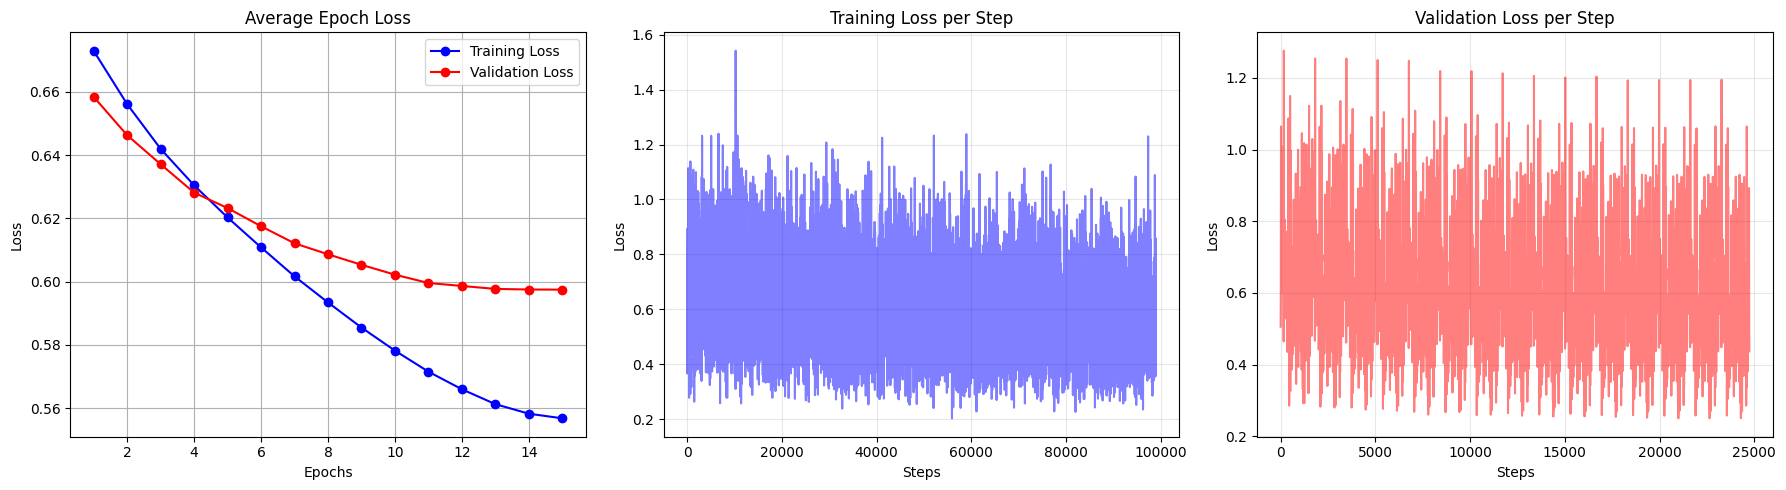

In [29]:
import matplotlib.pyplot as plt

# Create a figure with 3 subplots arranged in a single row
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# --- Plot A: Epoch-level Losses ---
# X-axis: Epoch numbers (1 to 5)
epochs_range = range(1, epochs + 1)
ax1.plot(epochs_range, epoch_train_losses, 'b-o', label='Training Loss')
ax1.plot(epochs_range, epoch_val_losses, 'r-o', label='Validation Loss')
ax1.set_title('Average Epoch Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# --- Plot B: Step-level Training Losses ---
# This shows the detailed fluctuation of loss during training
ax2.plot(all_train_step_nums, all_train_step_losses, color='blue', alpha=0.5)
ax2.set_title('Training Loss per Step')
ax2.set_xlabel('Steps')
ax2.set_ylabel('Loss')
ax2.grid(True, alpha=0.3)

# --- Plot C: Step-level Validation Losses ---
# This shows the loss calculated during validation checks
ax3.plot(all_val_step_nums, all_val_step_losses, color='red', alpha=0.5)
ax3.set_title('Validation Loss per Step')
ax3.set_xlabel('Steps')
ax3.set_ylabel('Loss')
ax3.grid(True, alpha=0.3)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

# Inference (15 Points)

Complete the function below to generate comments (positive or negative) 

In [30]:
def generate_comment(model: nn.Module, tokenizer: Any, sentiment: str, max_length: int = 50) -> str:
    # 1. Create the appropriate prefix based on the sentiment parameter
    if "positive" in sentiment.lower():
        prefix = "[POS]"
    elif "negative" in sentiment.lower():
        prefix = "[NEG]"
    else:
        # Fallback or default
        prefix = "[POS]" 
    
    # 2. Tokenize the prefix
    # We need to send the inputs to the same device (CPU/GPU) as the model
    device = next(model.parameters()).device
    
    # encode returns a list, so we convert to tensor and add batch dimension
    input_ids = tokenizer.encode(prefix, return_tensors='pt').to(device)

    # 3. Generate text using the model's generate method
    # We use the generate function inside our GPT2 class
    output_ids = model.generate(
        input_ids=input_ids, 
        max_new_tokens=max_length,
        temperature=1.0, # Controls creativity (higher = more creative)
        top_k=50,       # Limits choices to top 50 likely tokens
        top_p=0.95      # Nucleus sampling
    )

    # 4. Decode the generated IDs back to text
    # skip_special_tokens=True removes [POS], [NEG], and padding tokens from the result
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    return generated_text

# --- Example Usage ---
# print("Positive Comment:", generate_comment(model, tokenizer, "Positive"))
# print("Negative Comment:", generate_comment(model, tokenizer, "Negative"))

Generate 10 positive and 10 negative comments and evaluate your results

In [32]:
# TODO: Demonstrate the model's sentiment-controlled text generation

print(f"{'='*20} SENTIMENT CONTROL DEMO {'='*20}")

# Set the model to evaluation mode (disables dropout for deterministic results)
model.eval()

for i in range(10):
    # a. Generate a positive comment using the generate_comment function
    # We ask the model to complete the pattern starting with [POS]
    pos_comment = generate_comment(model, tokenizer, sentiment="positive", max_length=32)

    # b. Generate a negative comment using the generate_comment function
    # We ask the model to complete the pattern starting with [NEG]
    neg_comment = generate_comment(model, tokenizer, sentiment="negative", max_length=32)
    
    # Print the results side-by-side for comparison
    print(f"Sample {i+1}:")
    print(f"  Positive: {pos_comment}")
    print(f"  Negative: {neg_comment}")
    print("-" * 50)

==================== SENTIMENT CONTROL DEMO ====================
Sample 1:
  Positive:  خوب بود کیفیتش مناسب بود و خیلی سریع به دستم رسید
  Negative:  افتضاح بود من نمیدونم چرا شما کلا سفارش میدین من کاش به توضیحات اهمیت داده میشه لطفا به
--------------------------------------------------
Sample 2:
  Positive:  مثل همیشه عالی از ناتلی که خیلی راضیم
  Negative:  من با یک ماهی و سفارش دادم برام یک عدد فرستادند
--------------------------------------------------
Sample 3:
  Positive:  خیلی عالی بود و کاملا به موقع رسید
  Negative:  بسیار ضعیف بود
--------------------------------------------------
Sample 4:
  Positive:  با توجه به اینکه سفارش با رستوران فاصله مکانی کم بود اما حدود  دقیقه تاخیر داشت
  Negative:  جوجهها کیفیت مناسبی نداشتند و سوخته بود
--------------------------------------------------
Sample 5:
  Positive:  من دوست داشتم اما متاسفانه هر دو پیتزا مارگاریتا پنیری خوب نبود و بیشترش سس قارچ داشت
  Negative:  پیتزا کاملا یخ یخزده و بیکیفیت
----------------------------------------

## Inference Time Hyperparameters (10 Points)

Play with these parameters for the best results:
  
temperature, top_k, top_p

Briefly report what you saw and try to explain why is it happening. What is the effect of each one?

**Your Report**:  

In [33]:
test_text = "غذا خیلی خوشمزه بود"
encoded = tokenizer.encode(test_text)
decoded = tokenizer.decode(encoded)

print("Original:", test_text)
print("Encoded IDs:", encoded)
print("Decoded:", decoded)

Original: غذا خیلی خوشمزه بود
Encoded IDs: [128000, 82878, 101463, 113620, 112639, 10386, 105830, 100850]
Decoded: <|begin_of_text|>غذا خیلی خوشمزه بود
